In [9]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import ndimage
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.colors as pltc
from dext.postprocessing.detection_visualization import get_text_origin
import colorsys
import random
from matplotlib import gridspec
import pickle
from elo import Elo

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('text', usetex=True)
plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=2) # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath \usepackage{bm} \usepackage{amsmath}'

In [2]:
result_file = '/home/deepan/Downloads/dexttrustanalysis-default-rtdb-export.json'

type_1_values = {"Robot A explanation is \"much better\"": 2,
                 "Robot A explanation is \"slightly better\"": 1,
                 "Both explanations are \"same\"": 0,
                 "Robot A explanation is \"slightly worse\"": -1, 
                 "Robot A explanation is \"much worse\"": -2}

In [3]:
with open(result_file) as json_file:
    data = json.load(json_file)
    
with open('questions.pkl', 'rb') as f:
    all_questions = pickle.load(f)

In [105]:
model_answers = []
mov_answers = []
for user_id, full_answer in data['dexttrustanalysis-default-rtdb']['single_answer:'].items():
    q_id = list(full_answer.keys())[0]
    answer = full_answer[q_id]
    q_id = int(q_id)
    if q_id <= 100:
        model_answers.append([q_id, type_1_values[answer], type_1_values[answer] * (-1)])
    if q_id > 100:
        mov_answers.append([q_id, answer])
print(model_answers, mov_answers)    

[[46, 0, 0], [62, 0, 0], [26, 0, 0], [11, 0, 0], [88, 2, -2], [56, -1, 1], [48, -1, 1], [16, 2, -2], [58, 2, -2], [55, 0, 0]] [[123, 'Method 4'], [108, 'Method 4'], [105, 'Method 4'], [115, 'Method 4'], [113, 'Method 4']]


In [15]:
model_answers = np.array(model_answers)
# mov_answers = np.array(mov_answers)

In [23]:
methods_asked_in_model_questions = []
for i in all_questions[:100]:
    method_1 = i['images'][1].replace('trust_analysis/', '').split('_', 1)[1].split('/')[0]
    method_2 = i['images'][-1].replace('trust_analysis/', '').split('_', 1)[1].split('/')[0]
    assert method_1 != method_2
    methods_asked_in_model_questions.append([i['unique_id'], method_1, method_2])
methods_asked_in_model_questions = np.array(methods_asked_in_model_questions)

In [24]:
elo = Elo(10)
# Simple example
m1 = 1000
m2 = 1000
m3 = 1000
elo.expect(m1, m2)
# M1 wins M2
m1 = elo.rate(m1, [(2, m2)])
m2 = elo.rate(m2, [(-2, m1)])
# M3 wins M1
m3 = elo.rate(m3, [(2, m1)])
m1 = elo.rate(m1, [(-2, m3)])
# M2 wins M3
m2 = elo.rate(m2, [(2, m3)])
m3 = elo.rate(m3, [(-2, m2)])
m1, m2, m3
# Above example makes sense -- Therefore, proceeding to calculate rankings
# Reference: https://github.com/sublee/elo/

(990.0031046517942, 990.7888496681344, 989.8647802759169)

In [38]:
ratings = {'GuidedBackpropagation':1000, 'SmoothGrad_GuidedBackpropagation': 1000,
           'IntegratedGradients':1000, 'SmoothGrad_IntegratedGradients': 1000}
for answer in model_answers:
    method_1 = methods_asked_in_model_questions[answer[0] - 1][1]
    method_2 = methods_asked_in_model_questions[answer[0] - 1][2]
    print(method_1, method_2, answer[0], answer[1], answer[2])
    ratings[method_1] = elo.rate(ratings[method_1], [(answer[1], ratings[method_2])])
    ratings[method_2] = elo.rate(ratings[method_2], [(answer[2], ratings[method_1])])
print(ratings)

SmoothGrad_IntegratedGradients IntegratedGradients 46 0 0
GuidedBackpropagation IntegratedGradients 62 0 0
SmoothGrad_IntegratedGradients IntegratedGradients 26 0 0
IntegratedGradients GuidedBackpropagation 11 0 0
GuidedBackpropagation IntegratedGradients 88 2 -2
IntegratedGradients GuidedBackpropagation 56 -1 1
SmoothGrad_IntegratedGradients IntegratedGradients 48 -1 1
SmoothGrad_IntegratedGradients IntegratedGradients 16 2 -2
SmoothGrad_IntegratedGradients GuidedBackpropagation 58 2 -2
IntegratedGradients GuidedBackpropagation 55 0 0
{'GuidedBackpropagation': 977.6740792481462, 'SmoothGrad_GuidedBackpropagation': 1000, 'IntegratedGradients': 918.0808274696103, 'SmoothGrad_IntegratedGradients': 1004.1177381087729}


In [65]:
method_names = np.array([r'\textbf{GBP}', r'\textbf{SGBP}', 
                         r'\textbf{IG}', r'\textbf{SIG}'])
method_ratings = np.array([ratings['GuidedBackpropagation'], 
                           ratings['SmoothGrad_GuidedBackpropagation'], 
                           ratings['IntegratedGradients'], 
                           ratings['SmoothGrad_IntegratedGradients']])
order = np.argsort(method_ratings)[::-1]
ranked_ratings = method_ratings[order]
ranked_names = method_names[order]
print(ranked_names, ranked_ratings)

['\\textbf{SIG}' '\\textbf{SGBP}' '\\textbf{GBP}' '\\textbf{IG}'] [1004.11773811 1000.          977.67407925  918.08082747]


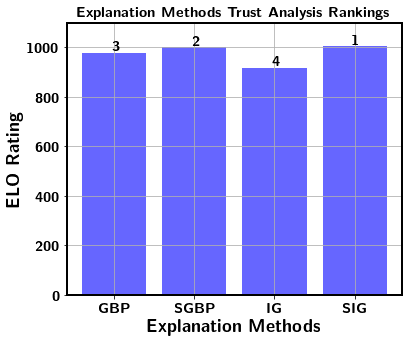

In [109]:
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(height=method_ratings, x=method_names, color='blue', alpha=0.6, capsize=10)
ax.set_xlabel(r'\textbf{Explanation Methods}', fontdict={'size':18}, fontweight='bold')
ax.set_ylabel(r'\textbf{ELO Rating}', fontdict={'size':18}, fontweight='bold')
ax.set_title(r'\textbf{%s}' % 'Explanation Methods Trust Analysis Rankings')
ax.grid('on')
ax.set_ylim([0, 1100])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.37, yval + 10,  # change constant to place text on top of bar
             r'\textbf{%s}' % str(1 + np.where(method_names[i] == ranked_names)[0][0]))
plt.savefig('methods_rank.pdf', dpi=300)

In [133]:
# Analyzing mov answers
# mov_answers.append([122, 'Method 2'])
# mov_answers.append([122, 'Method 1'])
# mov_answers.append([122, 'Method 3'])
# mov_answers.append([122, 'Method 2'])
# mov_answers.append([122, 'Method 2'])
# mov_answers.append([122, 'Method 3'])
# mov_answers.append([122, 'Method 1'])
# mov_answers = np.array(mov_answers)
mov_method_names = np.array([r'\textbf{%s}' % 'Method 1', r'\textbf{Method 2}', 
                             r'\textbf{%s}' % 'Method 3', 
                             r'\textbf{%s}' % 'Method 4'])
mov_method_name, mov_method_counts = np.unique(mov_answers[:, 1], return_counts=True)
print(mov_method_name, mov_method_counts)
for n, i in enumerate(mov_method_name):
    name = int(i.replace('Method ', ''))
    assert name == n + 1  

mov_order = np.argsort(mov_method_counts)[::-1]
rank_mov_method = mov_method_name[mov_order]
print(rank_mov_method)

['Method 1' 'Method 2' 'Method 3' 'Method 4'] [2 3 2 5]
['Method 4' 'Method 2' 'Method 3' 'Method 1']


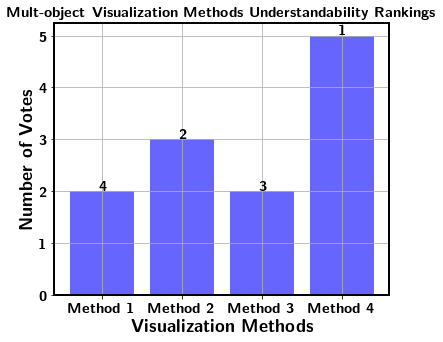

In [136]:
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(height=mov_method_counts, x=mov_method_names, color='blue', alpha=0.6, capsize=10)
ax.set_xlabel(r'\textbf{Visualization Methods}', fontdict={'size':18}, fontweight='bold')
ax.set_ylabel(r'\textbf{Number of Votes}', fontdict={'size':18}, fontweight='bold')
ax.set_title(r'\textbf{%s}' % 'Mult-object Visualization Methods Understandability Rankings')
ax.grid('on')
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.37, yval + 0.025,  # change constant to place text on top of bar
             r'\textbf{%s}' % str(1 + np.where(mov_method_name[i] == rank_mov_method)[0][0]))
plt.savefig('mov_rank.pdf', dpi=300)